## Packages and Assets

In [1]:
from gensim.models import Word2Vec
import json
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
import seaborn as sns
import keras_tuner as kt
from keras.optimizers import SGD

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

import matplotlib.pyplot as plt

from keras.preprocessing.text import tokenizer_from_json
import os, sys

In [2]:
print(sys.executable)
print(os.getcwd())

C:\Users\Guilherme\.conda\envs\nlp2\python.exe
C:\Users\Guilherme\Documents\Programming\Python\DataScience\TCC\pipeline\supervised_deep_models


## Dependencies

In [3]:
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index



In [4]:
model_we = Word2Vec.load('../../assets/deep_assets/word2vec.model')

print(model_we.wv.most_similar('itau'))

# List of nparrays of size 300
embeddings_dict = {}
for word in model_we.wv.index_to_key:
    embeddings_dict[word] = model_we.wv[word]

embeddings_on_this_context = np.zeros((len(word_index), 300))
for word, i in word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_on_this_context[i - 1] = embeddings_vector


[('itub4', 0.9894438982009888), ('banco', 0.9625048041343689), ('bbas3', 0.9558351635932922), ('bbdc4', 0.9518388509750366), ('bradesco', 0.9462378621101379), ('santander', 0.9438444972038269), ('unibanco', 0.9431132078170776), ('valioso', 0.9285449981689453), ('xpbr31', 0.9095613956451416), ('pagara', 0.8953273892402649)]


In [5]:
train = pd.read_csv('../../assets/data/splits/train/padded.csv')

## Functions

In [6]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text


def show_confusion_matrix(cm):
    print("Confusion Matrix")
    plt.figure(figsize=(10, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    plt.show()

## RNN Model

### Data transformation for model

In [7]:
X_train = train.to_numpy()[:, :-1]
y_train = train.to_numpy()[:, -1]

### Tuning Architecture Hyperparams using RandomSearch and Early Stopping

#### Test 1

In [8]:
# def build_model(hp):
#     model = Sequential([
#         Embedding(input_dim=len(word_index), output_dim=300, input_length=X_train.shape[1], trainable=False,
#                   weights=[embeddings_on_this_context]),
#         Bidirectional(LSTM(16, return_sequences=True)),
#         Dropout(hp.Float('rate_dp_1', 0, 0.4, step=0.1)),
#         Bidirectional(LSTM(16)),
#         Dense(64, 'tanh'),
#         Dropout(hp.Float('rate_dp_1', 0.1, 0.4, step=0.1)),
#         Dense(4, activation='softmax')
#     ])
#     loss = "sparse_categorical_crossentropy"
#     # optimizer = SGD(learning_rate=0.01)
#     metrics = ['accuracy']
#
#     model.compile(loss=loss, optimizer='adam', metrics=metrics)
#     return model
#
#
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

####  Test 2

In [9]:
def build_model(hp):
    model = Sequential([
    Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(hp.Choice('units_bilstm_1',[16,32,64]), return_sequences=True)),
    Dropout(hp.Float('rate_dp_1',0,0.3,step=0.1)),
    Bidirectional(LSTM(hp.Choice('units_bilstm_2',[16,32,64]))),
    Dense(hp.Choice('units_dense',[16,32,64]), hp.Choice(['activation','tanh']) ),
    Dropout(hp.Float('rate_dp_2',0,0.3,step=0.1)),
    Dense(4, activation='softmax')
])
    loss = "sparse_categorical_crossentropy"
    # optimizer = SGD(learning_rate=0.01)
    metrics = ['accuracy']

    model.compile(loss=loss,optimizer='adam',metrics=metrics)
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [10]:
# amanha testar dropout 0.0, 0.1, 0.2
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='../../assets/deep_assets',
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

Search space summary
Default search space size: 6
units_bilstm_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
rate_dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
units_bilstm_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
units_dense (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
rate_dp_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [11]:
tuner.search(X_train, y_train, epochs=4000, validation_split=0.1, callbacks=[es], batch_size=32, verbose=2)

Trial 10 Complete [00h 02m 32s]
val_accuracy: 0.8383713960647583

Best val_accuracy So Far: 0.8445404171943665
Total elapsed time: 00h 22m 44s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary()
 # 0.845774233341217

Results summary
Results in ../../assets/deep_assets\lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.0
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8445404171943665

Trial 02 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8439235091209412

Trial 01 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.2
units_bilstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8408389687538147

Trial 04 summary
Hyperparameters:
units_bilstm_1: 32
rate_dp_1: 0.1
units_bilstm_2: 64
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8389883041381836

Trial 09 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.0
Score: 0.8383713960647583

Trial 00 summary
Hyperparameters:
units_bilstm_1: 32
r

In [24]:
type(tuner.results_summary())

Results summary
Results in ../../assets/deep_assets\lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.0
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8445404171943665

Trial 02 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8439235091209412

Trial 01 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.2
units_bilstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8408389687538147

Trial 04 summary
Hyperparameters:
units_bilstm_1: 32
rate_dp_1: 0.1
units_bilstm_2: 64
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8389883041381836

Trial 09 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.0
Score: 0.8383713960647583

Trial 00 summary
Hyperparameters:
units_bilstm_1: 32
r

NoneType

In [26]:
with open('../../assets/deep_assets/tuner_results_10_attempts.txt', 'w') as f:
    f.write(str(tuner.results_summary()))


Results summary
Results in ../../assets/deep_assets\lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.0
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8445404171943665

Trial 02 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8439235091209412

Trial 01 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.2
units_bilstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8408389687538147

Trial 04 summary
Hyperparameters:
units_bilstm_1: 32
rate_dp_1: 0.1
units_bilstm_2: 64
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8389883041381836

Trial 09 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.0
Score: 0.8383713960647583

Trial 00 summary
Hyperparameters:
units_bilstm_1: 32
r

In [30]:
tuner.get_best_hyperparameters()[0].values
tuner.

{'units_bilstm_1': 16,
 'rate_dp_1': 0.0,
 'units_bilstm_2': 16,
 'units_dense': 64,
 'activation': 'tanh',
 'rate_dp_2': 0.2}

In [31]:
tuner.save()

In [32]:
best_model = tuner.get_best_models()[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           3278400   
                                                                 
 bidirectional (Bidirectiona  (None, 11, 32)           40576     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

#### Evaluation

### Tuning fit hyperparamters using GridSearch

In [14]:
# model = Sequential([
#     Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
#     Bidirectional(LSTM(64, return_sequences=True)),
#     # Dropout(0.29),
#     # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
#     Bidirectional(LSTM(64)),
#     Dense(32, activation='relu'),
#     # Dropout(0.73),
#     Dense(4, activation='softmax')
# ])
#
# model.summary()
#
# from keras.optimizers import SGD
#
# loss = "sparse_categorical_crossentropy"
# optimizer = 'adam'
# metrics = ['accuracy']
#
# model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
#
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#
#
# history = model.fit(X_train, y_train, epochs=4000, validation_data=(X_val,y_val), verbose=2, callbacks=[es])


In [15]:
# def architecture_tuned_model():
#     model = Sequential([
#         Embedding(input_dim=len(word_index), output_dim=300, input_length=X_train.shape[1], trainable=False,
#                   weights=[embeddings_on_this_context]),
#         Bidirectional(LSTM(32, return_sequences=True)),
#         Dropout(0.29),
#         Bidirectional(LSTM(16)),
#         Dense(64, 'tanh'),
#         Dropout(0.73),
#         Dense(4, activation='softmax')
#     ])
#     loss = "sparse_categorical_crossentropy"
#     optimizer = 'adam'
#     metrics = ['accuracy']
#
#     model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#     return model


In [16]:
# from keras.wrappers.scikit_learn import KerasClassifier
#
# model = KerasClassifier(build_fn=architecture_tuned_model, verbose=0)

In [17]:
# from sklearn.model_selection import GridSearchCV
#
# es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=5)
#
# param_grid = {'batch_size': [1,2,4,8]}
#
# gs = GridSearchCV(estimator=model,
#                   param_grid=param_grid,
#                   cv=5)
# gs.fit(X_train, y_train, callbacks=[es])
# print(f"Best results for {model.__class__.__name__}")
# print("Best Score of train set: " + str(gs.best_score_))
# print("Best estimator: " + str(gs.best_estimator_))
# print("Best parameter set: " + str(gs.best_params_))


In [18]:
# gs.best_estimator_.model.history.history
# # 0.7766810655593872

In [19]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# ax1.plot(gs.best_estimator_.model.history.history['accuracy'])
# ax1.plot(gs.best_estimator_.model.history.history['loss'])
# ax1.set_title('Model Accuracy')
# ax1.set_ylabel('Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')
#
# ax2.plot(gs.best_estimator_.model.history.history['loss'])
# ax2.plot(gs.best_estimator_.model.history.history['val_loss'])
# ax2.set_title('Model Loss')
# ax2.set_ylabel('Loss')
# ax2.set_xlabel('Epoch')
# ax2.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

### Tuning fit hyperparameters manually

In [43]:
# model = Sequential([
#     Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
#     Bidirectional(LSTM(4, return_sequences=True)),
#     # Dropout(0.29),
#     # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
#     Bidirectional(LSTM(4)),
#     Dense(32, activation='relu'),
#     # Dropout(0.73),
#     Dense(4, activation='softmax')
# ])
#
# model.summary()

from keras.optimizers import SGD

loss = "sparse_categorical_crossentropy"
optimizer = 'adam'
metrics = ['accuracy']




best_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


best_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           3278400   
                                                                 
 bidirectional (Bidirectiona  (None, 11, 32)           40576     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [44]:
history = best_model.fit(X_train, y_train, epochs=4000, batch_size=32, validation_split=0.1, verbose=2, callbacks=[es])

Epoch 1/4000
456/456 - 15s - loss: 0.3658 - accuracy: 0.8681 - val_loss: 0.4835 - val_accuracy: 0.8396 - 15s/epoch - 33ms/step
Epoch 2/4000
456/456 - 5s - loss: 0.3623 - accuracy: 0.8713 - val_loss: 0.4942 - val_accuracy: 0.8316 - 5s/epoch - 11ms/step
Epoch 3/4000
456/456 - 5s - loss: 0.3566 - accuracy: 0.8734 - val_loss: 0.4943 - val_accuracy: 0.8322 - 5s/epoch - 10ms/step
Epoch 4/4000
456/456 - 5s - loss: 0.3518 - accuracy: 0.8746 - val_loss: 0.5086 - val_accuracy: 0.8353 - 5s/epoch - 10ms/step
Epoch 5/4000
456/456 - 5s - loss: 0.3455 - accuracy: 0.8765 - val_loss: 0.5019 - val_accuracy: 0.8415 - 5s/epoch - 10ms/step
Epoch 6/4000
456/456 - 5s - loss: 0.3452 - accuracy: 0.8763 - val_loss: 0.4974 - val_accuracy: 0.8359 - 5s/epoch - 10ms/step
Epoch 7/4000
456/456 - 5s - loss: 0.3404 - accuracy: 0.8812 - val_loss: 0.5105 - val_accuracy: 0.8384 - 5s/epoch - 10ms/step
Epoch 8/4000
456/456 - 5s - loss: 0.3353 - accuracy: 0.8831 - val_loss: 0.5102 - val_accuracy: 0.8304 - 5s/epoch - 10ms/ste

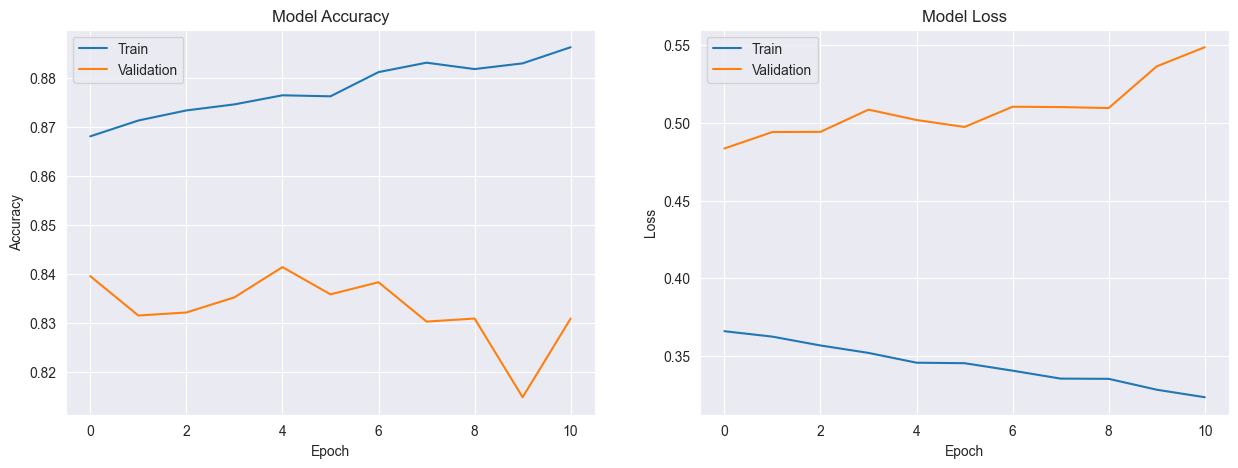

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Exporting model

In [48]:
best_model.save('../../assets/deep_assets/lstm_model')

INFO:tensorflow:Assets written to: ../../assets/deep_assets/lstm_model\assets


INFO:tensorflow:Assets written to: ../../assets/deep_assets/lstm_model\assets
